# Data

The dataset includes information about calls that took place during previous telemarketing campaigns.

- age: age of the client
- balance: balance on the client's account (€)
- campaign: number of contacts performed during this campaign and for this client
- day: day of the month when the call took place
- default: whether the client credit in default ('yes':1, 'no':0)
- duration: last call duration (in seconds)
- education: client's education ('tertiary', 'secondary', 'unknown', 'primary')
- housing: whether the client has housing loan ('yes':1, 'no':0)
- loan: whether the client has personal loan ('yes':1, 'no':0)
- marital: marital status('married':1, 'not married':0)
- previous: number of contacts performed before this campaign and for this client
- poutcome: outcome of the previous marketing campaign
- subscription: whether the client subscribed to a term deposit after the call ('yes':1, 'no':0).

# Libraries and data import

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import csv
import random
import seaborn as sns
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from IPython.display import Image
import pydotplus
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, equalized_odds_difference
from fairlearn.reductions import GridSearch, DemographicParity

In [11]:
df = pd.read_csv('./bank-full.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscription
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# Data preprocessing

## 1. Data cleaning

Check if there is missing values

In [57]:
missing_values = df.isnull().sum()
missing_values

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
subscription    0
gender          0
dtype: int64

One-hot encoding of categorical variables. <br/>
**Dummy variable trap**: I keep n-1 unique value for each column, the remaining value is the one reference category. It prevents from multicollinearity 

In [135]:
total_job_values = df['job'].nunique()
total_job_values

12

Encode boolean attributes

In [12]:
boolean_columns = ['default', 'housing', 'loan', 'subscription']

# Mapping dictionary for replacement
mapping = {'no': 0, 'yes': 1}

# Loop through boolean columns and replace values
for column in boolean_columns:
    df[column] = df[column].replace(mapping)

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscription
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0


Generate gender attribute with 0.9 conditional probability to be subscribed knowing gender = male and 0.1 conditional probability to be subscribed knowing that gender = female

In [13]:
prob_male_given_subscribed = 0.75
prob_female_given_subscribed = 0.25
prob_male_given_unsubscribed = 0.45
prob_female_given_unsubscribed = 0.55


# Update the 'gender' column based on the 'subscription' values
for index, row in df.iterrows():
    if row['subscription'] == 1:
        df.at[index, 'gender'] = np.random.choice([0, 1], p=[prob_male_given_subscribed, prob_female_given_subscribed])
    else:
        df.at[index, 'gender'] = np.random.choice([0, 1], p=[prob_female_given_unsubscribed, prob_male_given_unsubscribed])
df['gender'] = df['gender'].astype(int)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscription,gender
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0,1
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0,1
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1,0
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1,0
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1,0
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0,1


In [14]:
mean_subscription_given_gender = df.groupby('gender')['subscription'].mean()
mean_subscription_given_gender

gender
0    0.178367
1    0.058836
Name: subscription, dtype: float64

In [15]:
contingency_table = pd.crosstab(df['subscription'], df['gender'])
contingency_table

gender,0,1
subscription,,
0,18071,21851
1,3923,1366


Encode one-hot categorical attributes

In [16]:
# Columns to be one-hot encoded
columns_to_encode = ['job', 'marital', 'education', 'contact', 'poutcome']

# Initialize an empty dataframe
df_temp = pd.DataFrame()

# Iterate over each column and perform one-hot encoding
for column in columns_to_encode:
    dummies = pd.get_dummies(df[column], prefix=f"{column}_is", drop_first=True)
    df_temp = pd.concat([df_temp, dummies], axis=1)

df_concat = pd.concat([df, df_temp], axis=1)
# Drop the original columns
df_concat.drop(columns_to_encode, axis=1, inplace=True)
df_concat

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_is_married,marital_is_single,education_is_secondary,education_is_tertiary,education_is_unknown,contact_is_telephone,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown
0,58,0,2143,1,0,5,may,261,1,-1,...,1,0,0,1,0,0,1,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,...,0,1,1,0,0,0,1,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,...,1,0,1,0,0,0,1,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,...,1,0,0,0,1,0,1,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,...,0,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,nov,977,3,-1,...,1,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,nov,456,2,-1,...,0,0,0,0,0,0,0,0,0,1
45208,72,0,5715,0,0,17,nov,1127,5,184,...,1,0,1,0,0,0,0,0,1,0
45209,57,0,668,0,0,17,nov,508,4,-1,...,1,0,1,0,0,1,0,0,0,1


## 2. Data exploration

In [127]:
statistics_table = df_concat.describe()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Calculate skewness and kurtosis for each column
    statistics_table.loc['median'] = df_concat.median()
    statistics_table.loc['skewness'] = df_concat.skew()
    statistics_table.loc['kurtosis'] = df_concat.kurtosis()
statistics_table

,default,housing,loan,day,subscription,gender,job_is_blue-collar,job_is_entrepreneur,job_is_housemaid,job_is_management,...,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown,age_zscore,balance_zscore,duration_zscore,campaign_zscore,pdays_zscore,previous_zscore
count,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,...,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000
mean,0.018027,0.555850,0.160230,15.806392,0.116987,0.513515,0.215262,0.032869,0.027428,0.209202,...,0.287989,0.040677,0.033422,0.817496,0.000008,-0.000012,-0.000009,0.000005,-0.000033,-0.000100
std,0.133050,0.496876,0.366823,8.322566,0.321409,0.499823,0.411009,0.178295,0.163328,0.406743,...,0.452831,0.197543,0.179737,0.386264,1.000021,1.000019,1.000020,1.000021,0.999998,0.999796
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.159994,-3.081149,-1.002478,-0.569351,-0.411453,-0.251940
25%,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-0.747384,-0.423772,-0.602517,-0.569351,-0.411453,-0.251940
50%,0.000000,1.000000,0.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-0.182341,-0.300280,-0.303517,-0.246560,-0.411453,-0.251940
75%,0.000000,1.000000,0.000000,21.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.665225,0.021505,0.236237,0.076230,-0.411453,-0.251940
max,1.000000,1.000000,1.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,5.091402,33.094776,18.094700,19.443647,8.297431,119.135982
median,0.000000,1.000000,0.000000,16.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,-0.182341,-0.300280,-0.303517,-0.246560,-0.411453,-0.251940
skewness,7.245290,-0.224816,1.852581,0.093087,2.383441,-0.054080,1.385618,5.240207,5.787063,1.429951,...,0.936420,4.650575,5.192008,-1.644008,0.684790,8.360325,3.144325,4.898590,2.615902,41.872669


Descriptive statistics of target variable

### Insights: 
- mean: 11.7% of people subscribed
- count: 5289 people subscribed

In [18]:
statistics_table['subscription']

count       45211.000000
mean            0.116985
std             0.321406
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max             1.000000
median          0.000000
skewness        2.383480
kurtosis        3.681142
Name: subscription, dtype: float64

In [19]:
df_concat['subscription'].value_counts()[1]

5289

In [20]:
statistics_table['gender']

count       45211.000000
mean            0.513525
std             0.499823
min             0.000000
25%             0.000000
50%             1.000000
75%             1.000000
max             1.000000
median          1.000000
skewness       -0.054123
kurtosis       -1.997159
Name: gender, dtype: float64

Count of females

In [323]:
df_concat['gender'].value_counts()[1]

23365

Ratio of females

In [21]:
# Count the number of female observations
female_count = (df['gender'] == 1).sum()

# Compute the female ratio
total_count = len(df)
female_ratio = female_count / total_count
female_ratio

0.5135254694653956

### Insights:
- age: light left asymmetry 
- balance: very large standard deviation value and kurtosis, asymmetric distribution
- duration: heavy left asymmetry, difference between mean and median is about 80 seconds
- campaign: heavy left asymmetry
- pdays: more than 50% of the clients have a value of -1, heavy left asymmetry
- previous: more than 50% of client have not been contacted before this campaign


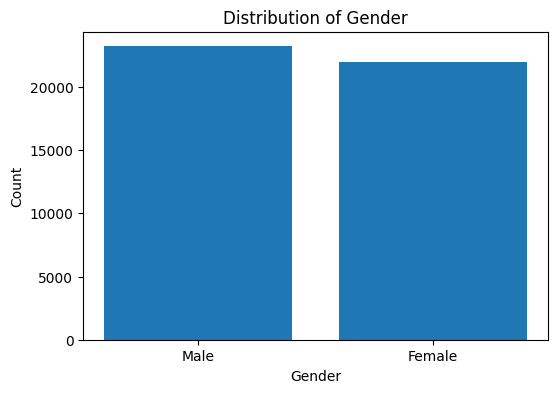

In [22]:
plt.figure(figsize=(6, 4))
counts = df_concat['gender'].value_counts()
plt.bar(['Male', 'Female'], counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.show()

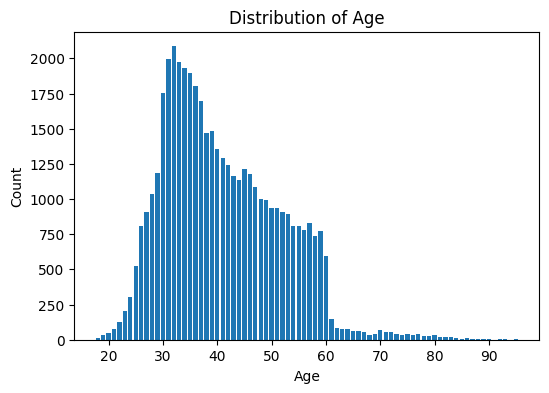

In [148]:
plt.figure(figsize=(6, 4))  # Set the size of the figure
plt.bar(df_concat['age'].value_counts().index, df_concat['age'].value_counts().values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show()

### Insights: 
Outliers break the barchart, some observations have more than 100,000 in balance. Skeweness and standard deviation suggested non-normal distribution. 

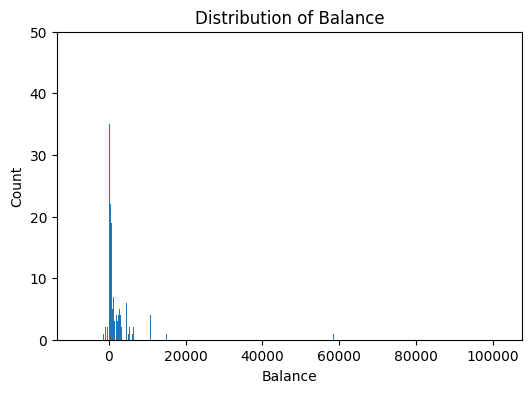

In [17]:
plt.figure(figsize=(6, 4))  # Set the size of the figure
plt.bar(df_concat['balance'].value_counts().index, df_concat['balance'].value_counts().values)
plt.xlabel('Balance')
plt.ylabel('Count')
plt.title('Distribution of Balance')
plt.ylim(0, 50)
plt.show()

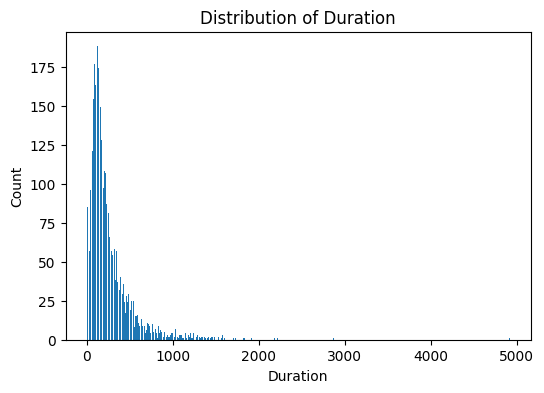

In [70]:
plt.figure(figsize=(6, 4)) 
plt.bar(df_concat['duration'].value_counts().index, df_concat['duration'].value_counts().values)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Distribution of Duration')
plt.show()

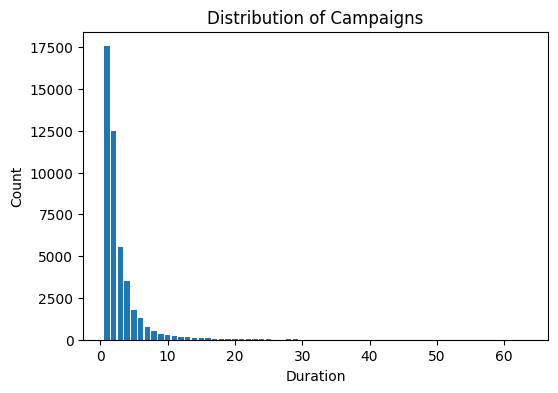

In [71]:
plt.figure(figsize=(6, 4)) 
plt.bar(df_concat['campaign'].value_counts().index, df_concat['campaign'].value_counts().values)
plt.xlabel('Campaign')
plt.ylabel('Count')
plt.title('Distribution of Campaigns')
plt.show()

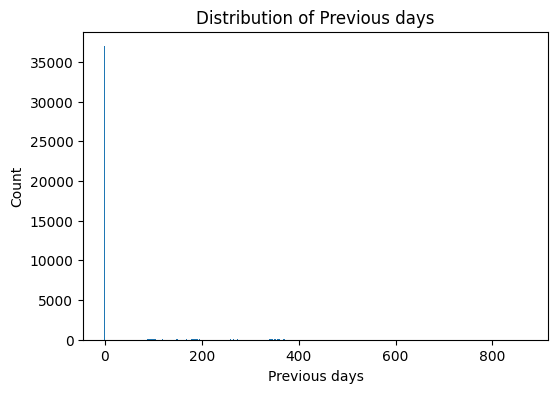

In [86]:
plt.figure(figsize=(6, 4))
plt.bar(df_concat['pdays'].value_counts().index, df_concat['pdays'].value_counts().values)
plt.xlabel('Previous days')
plt.ylabel('Count')
plt.title('Distribution of Previous days')
plt.show()

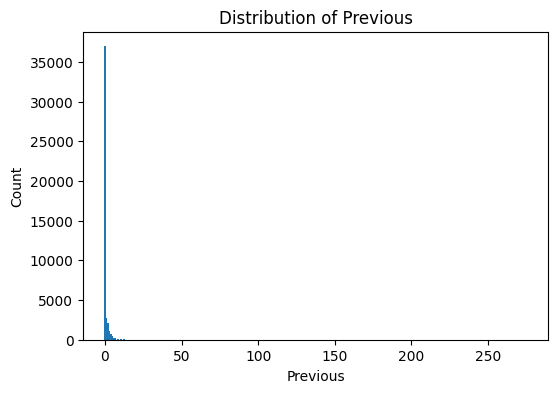

In [72]:
plt.figure(figsize=(6, 4)) 
plt.bar(df_concat['previous'].value_counts().index, df_concat['previous'].value_counts().values)
plt.xlabel('Previous')
plt.ylabel('Count')
plt.title('Distribution of Previous')
plt.show()

## 3. Data normalisation

Apply a z-score transformation

In [23]:
variables_to_normalise = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
for variable in variables_to_normalise: 
    zscores = zscore(df_concat[variable]) # Compute z-score of each column in the list
    zscore_column_name = f"{variable}_zscore" # Add the column to the df
    df_concat[zscore_column_name] = zscores
    df_concat = df_concat.drop([variable], axis=1)
df_concat

,default,housing,loan,day,month,subscription,gender,job_is_blue-collar,job_is_entrepreneur,job_is_housemaid,...,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown,age_zscore,balance_zscore,duration_zscore,campaign_zscore,pdays_zscore,previous_zscore
0,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.251940
1,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.251940
2,0,1,1,5,may,0,0,0,1,0,...,1,0,0,1,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.251940
3,0,1,0,5,may,0,1,1,0,0,...,1,0,0,1,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.251940
4,0,0,0,5,may,0,1,0,0,0,...,1,0,0,1,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.251940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,1,0.947747,-0.176460,2.791329,0.076230,-0.411453,-0.251940
45207,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,1,2.831227,0.120447,0.768224,-0.246560,-0.411453,-0.251940
45208,0,0,0,17,nov,1,0,0,0,0,...,0,0,1,0,2.925401,1.429593,3.373797,0.721811,1.436189,1.050473
45209,0,0,0,17,nov,0,1,1,0,0,...,0,0,0,1,1.512791,-0.228024,0.970146,0.399020,-0.411453,-0.251940


In [24]:
df_concat.to_csv('bank-full-transformed.csv', index=False)

Filter the rows of the dataframe for which at least one column of the z-score columns has an absolute value above 3. 

In [25]:
zscore_columns = ['age_zscore', 'balance_zscore', 'duration_zscore', 'campaign_zscore', 'pdays_zscore', 'previous_zscore']

# Apply boolean indexing to filter the rows
df_outliers = df_concat[(df_concat[zscore_columns].abs() > 3).any(axis=1)]

df_outliers

,default,housing,loan,day,month,subscription,gender,job_is_blue-collar,job_is_entrepreneur,job_is_housemaid,...,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown,age_zscore,balance_zscore,duration_zscore,campaign_zscore,pdays_zscore,previous_zscore
34,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,0.947747,3.045499,0.302250,-0.569351,-0.411453,-0.251940
37,0,0,0,5,may,0,0,0,0,0,...,1,0,0,1,1.136095,-0.448405,5.466798,-0.569351,-0.411453,-0.251940
43,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,1.230269,-0.273677,4.791135,-0.569351,-0.411453,-0.251940
59,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,0.476877,-0.388629,5.901707,-0.569351,-0.411453,-0.251940
69,0,1,1,5,may,0,0,1,0,0,...,1,0,0,1,-0.559037,3.567055,-0.315166,-0.569351,-0.411453,-0.251940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45199,0,1,0,16,nov,0,1,1,0,0,...,0,1,0,0,-0.653211,0.037024,3.525239,0.076230,4.891778,4.957714
45200,0,1,0,16,nov,1,1,0,0,0,...,0,0,0,1,-0.276515,-0.264480,5.039655,0.399020,-0.411453,-0.251940
45204,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,0,3.019575,0.488624,0.162458,-0.569351,-0.001976,3.221163
45208,0,0,0,17,nov,1,0,0,0,0,...,0,0,1,0,2.925401,1.429593,3.373797,0.721811,1.436189,1.050473


Percentage of outliers given that rule

In [26]:
percentage_outliers = round((df_outliers.shape[0]/df_concat.shape[0])*100, 4)
print(f'{percentage_outliers}%')

11.0637%


In [27]:
df_filtered = df_concat.merge(df_outliers, how='left', indicator=True)
df_filtered = df_filtered[df_filtered['_merge'] == 'left_only']
df_filtered = df_filtered.drop(columns='_merge')
df_filtered

,default,housing,loan,day,month,subscription,gender,job_is_blue-collar,job_is_entrepreneur,job_is_housemaid,...,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown,age_zscore,balance_zscore,duration_zscore,campaign_zscore,pdays_zscore,previous_zscore
0,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,1.606965,0.256419,0.011016,-0.569351,-0.411453,-0.25194
1,0,1,0,5,may,0,1,0,0,0,...,1,0,0,1,0.288529,-0.437895,-0.416127,-0.569351,-0.411453,-0.25194
2,0,1,1,5,may,0,0,0,1,0,...,1,0,0,1,-0.747384,-0.446762,-0.707361,-0.569351,-0.411453,-0.25194
3,0,1,0,5,may,0,1,1,0,0,...,1,0,0,1,0.571051,0.047205,-0.645231,-0.569351,-0.411453,-0.25194
4,0,0,0,5,may,0,1,0,0,0,...,1,0,0,1,-0.747384,-0.447091,-0.233620,-0.569351,-0.411453,-0.25194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,1,-1.689124,-0.410306,0.030432,-0.569351,-0.411453,-0.25194
45205,0,0,1,17,nov,1,0,0,0,0,...,0,0,0,1,-1.500776,-0.281559,0.496406,-0.246560,-0.411453,-0.25194
45206,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,1,0.947747,-0.176460,2.791329,0.076230,-0.411453,-0.25194
45207,0,0,0,17,nov,1,0,0,0,0,...,0,0,0,1,2.831227,0.120447,0.768224,-0.246560,-0.411453,-0.25194


In [28]:
df_filtered.to_csv('bank-full-filtered.csv', index=False)

# ML models

## 1. Context

You have been contacted by a banking institution that is willing to leverage its data to improve its telemarketing strategy.

As it wants to decrease its exposure to international credit markets, the bank decided to launch a telemarketing campaign in order to increase the amount of clients' deposits. Higher level of deposits means lower needs to borrow money on credit markets.
The bank has accumulated data from previous telemarketing campaigns and asks you to analyse it to assess whether you can predict which customers are likely to submit a new deposit. If your analysis enables to identify high potential clients, it will allow the bank to allocate its efforts on highest potential clients.

In order to tackle that challenge you decided to use machine learning algorithms that you have learned in Data Management & Analytics classes.

### Output variable: **subscription**

## 2. Feature Selection

In [29]:
correlation_matrix = df_concat.corr()
correlation_matrix

/var/folders/9z/ss1v3r3n1q79hcgm5mgp_6f80000gn/T/ipykernel_5106/4037070012.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_concat.corr()


,default,housing,loan,day,subscription,gender,job_is_blue-collar,job_is_entrepreneur,job_is_housemaid,job_is_management,...,contact_is_unknown,poutcome_is_other,poutcome_is_success,poutcome_is_unknown,age_zscore,balance_zscore,duration_zscore,campaign_zscore,pdays_zscore,previous_zscore
default,1.000000,-0.006025,0.077234,0.009424,-0.022419,0.003152,0.010341,0.026281,-0.000359,-0.002655,...,0.019933,-0.014445,-0.023344,0.039490,-0.017879,-0.066745,-0.010021,0.016822,-0.029979,-0.018329
housing,-0.006025,1.000000,0.041323,-0.027982,-0.139173,0.028599,0.177475,0.010600,-0.079380,-0.063382,...,0.208409,0.039710,-0.091360,-0.063755,-0.185513,-0.068768,0.005075,-0.023599,0.124178,0.037076
loan,0.077234,0.041323,1.000000,0.011370,-0.068185,0.014238,0.018291,0.039808,-0.017234,-0.038904,...,-0.007211,-0.009099,-0.053713,0.031406,-0.015655,-0.084350,-0.012412,0.009980,-0.022754,-0.011043
day,0.009424,-0.027982,0.011370,1.000000,-0.028348,0.012046,-0.022898,-0.002312,0.003955,0.019021,...,-0.034103,-0.032952,-0.030321,0.086256,-0.009120,0.004503,-0.030206,0.162490,-0.093044,-0.051710
subscription,-0.022419,-0.139173,-0.068185,-0.028348,1.000000,-0.185884,-0.072083,-0.019662,-0.015195,0.032919,...,-0.150935,0.031955,0.306788,-0.167051,0.025155,0.052838,0.394521,-0.073172,0.103621,0.093236
gender,0.003152,0.028599,0.014238,0.012046,-0.185884,1.000000,0.019744,0.003322,-0.002919,-0.006520,...,0.026376,-0.006694,-0.048981,0.025733,-0.007339,-0.011190,-0.076979,0.014040,-0.015780,-0.017855
job_is_blue-collar,0.010341,0.177475,0.018291,-0.022898,-0.072083,0.019744,1.000000,-0.096585,-0.087951,-0.269376,...,0.138141,0.001342,-0.053074,0.022194,-0.044002,-0.048757,0.009637,0.008986,0.020063,-0.017095
job_is_entrepreneur,0.026281,0.010600,0.039808,-0.002312,-0.019662,0.003322,-0.096585,1.000000,-0.030969,-0.094850,...,0.004867,-0.013506,-0.019111,0.014901,0.021792,0.009642,-0.001327,0.002128,-0.014203,-0.008181
job_is_housemaid,-0.000359,-0.079380,-0.017234,0.003955,-0.015195,-0.002919,-0.087951,-0.030969,1.000000,-0.086372,...,-0.004815,-0.016769,-0.009375,0.026059,0.086650,0.001661,-0.008046,0.003097,-0.031350,-0.015204
job_is_management,-0.002655,-0.063382,-0.038904,0.019021,0.032919,-0.006520,-0.269376,-0.094850,-0.086372,1.000000,...,-0.090999,0.002223,0.021453,-0.013755,-0.023571,0.067797,-0.008323,0.016686,-0.007871,0.019579


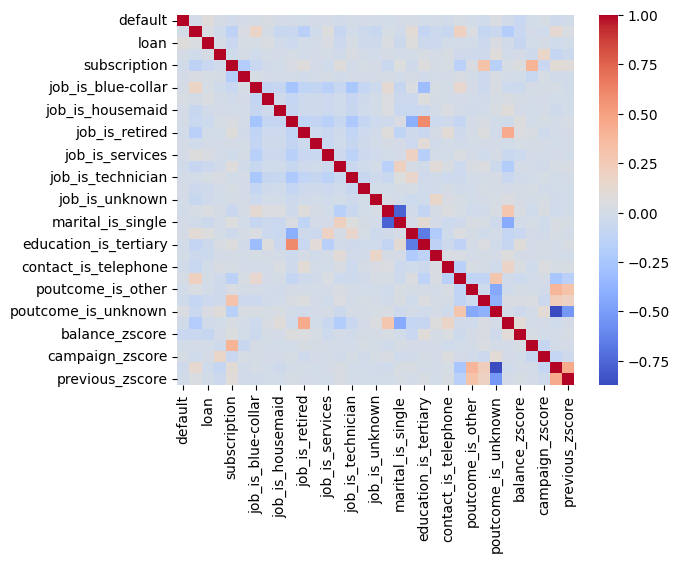

In [30]:
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.show()

In [31]:
target_correlation = correlation_matrix['subscription']
target_correlation

default                  -0.022419
housing                  -0.139173
loan                     -0.068185
day                      -0.028348
subscription              1.000000
gender                   -0.185884
job_is_blue-collar       -0.072083
job_is_entrepreneur      -0.019662
job_is_housemaid         -0.015195
job_is_management         0.032919
job_is_retired            0.079245
job_is_self-employed      0.000855
job_is_services          -0.027864
job_is_student            0.076897
job_is_technician        -0.008970
job_is_unemployed         0.020390
job_is_unknown            0.000267
marital_is_married       -0.060260
marital_is_single         0.063526
education_is_secondary   -0.036388
education_is_tertiary     0.066448
education_is_unknown      0.012053
contact_is_telephone      0.014042
contact_is_unknown       -0.150935
poutcome_is_other         0.031955
poutcome_is_success       0.306788
poutcome_is_unknown      -0.167051
age_zscore                0.025155
balance_zscore      

In [32]:
top_10_features = target_correlation.abs().nlargest(11)[1:]
top_10_features

duration_zscore        0.394521
poutcome_is_success    0.306788
gender                 0.185884
poutcome_is_unknown    0.167051
contact_is_unknown     0.150935
housing                0.139173
pdays_zscore           0.103621
previous_zscore        0.093236
job_is_retired         0.079245
job_is_student         0.076897
Name: subscription, dtype: float64

In [33]:
top_10_feature_names = top_10_features.index.tolist()
top_10_feature_names

['duration_zscore',
 'poutcome_is_success',
 'gender',
 'poutcome_is_unknown',
 'contact_is_unknown',
 'housing',
 'pdays_zscore',
 'previous_zscore',
 'job_is_retired',
 'job_is_student']

### a. full dataframe

In [34]:
# Splitting into features (X) and target (Y)
full_df_target = df_concat['subscription']
full_df_target

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: subscription, Length: 45211, dtype: int64

In [35]:
full_df_features = df_concat.loc[:, top_10_feature_names]
full_df_features

,duration_zscore,poutcome_is_success,gender,poutcome_is_unknown,contact_is_unknown,housing,pdays_zscore,previous_zscore,job_is_retired,job_is_student
0,0.011016,0,1,1,1,1,-0.411453,-0.251940,0,0
1,-0.416127,0,1,1,1,1,-0.411453,-0.251940,0,0
2,-0.707361,0,0,1,1,1,-0.411453,-0.251940,0,0
3,-0.645231,0,1,1,1,1,-0.411453,-0.251940,0,0
4,-0.233620,0,1,1,1,0,-0.411453,-0.251940,0,0
...,...,...,...,...,...,...,...,...,...,...
45206,2.791329,0,0,1,0,0,-0.411453,-0.251940,0,0
45207,0.768224,0,0,1,0,0,-0.411453,-0.251940,1,0
45208,3.373797,1,0,0,0,0,1.436189,1.050473,1,0
45209,0.970146,0,1,1,0,0,-0.411453,-0.251940,0,0


### b. filtered dataframe

In [286]:
# Splitting into features (X) and target (Y)
filtered_df_target = df_filtered['subscription']
filtered_df_target

0        0
1        0
2        0
3        0
4        0
        ..
45203    1
45205    1
45206    1
45207    1
45209    0
Name: subscription, Length: 40209, dtype: int64

In [287]:
filtered_df_features = df_filtered.loc[:, top_10_feature_names]
filtered_df_features

,duration_zscore,poutcome_is_success,gender,poutcome_is_unknown,contact_is_unknown,housing,pdays_zscore,previous_zscore,job_is_retired,job_is_student
0,0.011016,0,0,1,1,1,-0.411453,-0.25194,0,0
1,-0.416127,0,1,1,1,1,-0.411453,-0.25194,0,0
2,-0.707361,0,0,1,1,1,-0.411453,-0.25194,0,0
3,-0.645231,0,1,1,1,1,-0.411453,-0.25194,0,0
4,-0.233620,0,0,1,1,0,-0.411453,-0.25194,0,0
...,...,...,...,...,...,...,...,...,...,...
45203,0.030432,0,0,1,0,0,-0.411453,-0.25194,0,1
45205,0.496406,0,1,1,0,0,-0.411453,-0.25194,0,0
45206,2.791329,0,1,1,0,0,-0.411453,-0.25194,0,0
45207,0.768224,0,1,1,0,0,-0.411453,-0.25194,1,0


## 3. Training-Testing Split Strategy

### a. full dataframe

50/50 strategy

In [118]:
# Splitting into training and testing sets
full_df_features_train_5050, full_df_features_test_5050, full_df_target_train_5050, full_df_target_test_5050 = train_test_split(full_df_features, full_df_target, test_size=0.5, random_state=42)

80/20 strategy

In [290]:
full_df_features_train_8020, full_df_features_test_8020, full_df_target_train_8020, full_df_target_test_8020 = train_test_split(full_df_features, full_df_target, test_size=0.2, random_state=21)

### b. filtered dataframe

In [289]:
filtered_df_features_train_5050, filtered_df_features_test_5050, filtered_df_target_train_5050, filtered_df_target_test_5050 = train_test_split(filtered_df_features, filtered_df_target, test_size=0.5, random_state=42)

## 4. ML Models

## 4.1. ML models without fairness constraint

## a) Decision tree

### 1) 50/50 split strategy on full dataset

In [346]:
depths = np.arange(1, 11)

dt_full_df_training_accuracies = []
dt_full_df_testing_accuracies = []

for depth in depths:
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=0.05)
    dt_fit = dt.fit(full_df_features_train_5050, full_df_target_train_5050)
    dt_full_df_training_accuracy = dt_fit.score(full_df_features_train_5050, full_df_target_train_5050) 
    dt_full_df_testing_accuracy = dt_fit.score(full_df_features_test_5050, full_df_target_test_5050)
    dt_full_df_training_accuracies.append(dt_full_df_training_accuracy)
    dt_full_df_testing_accuracies.append(dt_full_df_testing_accuracy)
    print(f" Depth:{depth}, decision tree training accuracy: {round(dt_full_df_training_accuracy, 4)}, decision tree testing accuracy: {round(dt_full_df_testing_accuracy, 4)}")

 Depth:1, decision tree training accuracy: 0.8837, decision tree testing accuracy: 0.8823
 Depth:2, decision tree training accuracy: 0.8912, decision tree testing accuracy: 0.8901
 Depth:3, decision tree training accuracy: 0.9032, decision tree testing accuracy: 0.9021
 Depth:4, decision tree training accuracy: 0.9032, decision tree testing accuracy: 0.9021
 Depth:5, decision tree training accuracy: 0.9032, decision tree testing accuracy: 0.9021
 Depth:6, decision tree training accuracy: 0.9032, decision tree testing accuracy: 0.9021
 Depth:7, decision tree training accuracy: 0.9036, decision tree testing accuracy: 0.9021
 Depth:8, decision tree training accuracy: 0.9036, decision tree testing accuracy: 0.9021
 Depth:9, decision tree training accuracy: 0.9036, decision tree testing accuracy: 0.9021
 Depth:10, decision tree training accuracy: 0.9036, decision tree testing accuracy: 0.9021


Optimal depth is 3

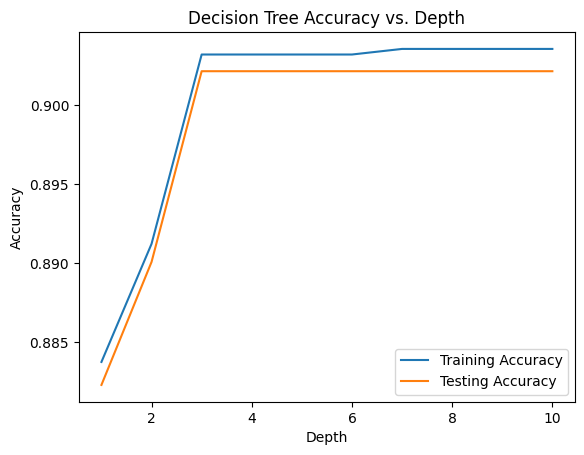

In [347]:
plt.plot(depths, dt_full_df_training_accuracies, label='Training Accuracy')
plt.plot(depths, dt_full_df_testing_accuracies, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.show()

Accuracy = (True Positive + True Negative) / (True Positive + True Negative + False Positive + False Negative)

Precision = True Positive / (True Positive + False Positive)

Recall = True Positive / (True Positive + False Negative)

In [293]:
dt_opti = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=0.05)
dt_opti_fit = dt_opti.fit(full_df_features_train_5050, full_df_target_train_5050)
dt_training_accuracy = dt_opti.score(full_df_features_train_5050, full_df_target_train_5050)
dt_testing_accuracy = dt_opti.score(full_df_features_test_5050, full_df_target_test_5050)
dt_precision_test = precision_score(full_df_target_test_5050, dt_opti.predict(full_df_features_test_5050))
dt_recall_test = recall_score(full_df_target_test_5050, dt_opti.predict(full_df_features_test_5050))
print(f"optimal decision tree training accuracy: {round(dt_training_accuracy, 4)}")
print(f"optimal decision tree testing accuracy: {round(dt_testing_accuracy, 4)}")
print(f"optimal decision tree testing precision: {round(dt_precision_test, 4)}")
print(f"optimal decision tree testing recall: {round(dt_recall_test, 4)}")

optimal decision tree training accuracy: 0.8998
optimal decision tree testing accuracy: 0.8982
optimal decision tree testing precision: 0.6197
optimal decision tree testing recall: 0.3502


In [35]:
dt_opti.predict(full_df_features_train_5050)

array([0, 0, 1, ..., 0, 0, 0])

In [348]:
for feature_imp, variable in zip(dt_opti_fit.feature_importances_,top_10_feature_names):
    print(f"{variable}:{round(feature_imp*100,1)}%")

duration_zscore:67.1%
poutcome_is_success:24.7%
gender:8.2%
poutcome_is_unknown:0.0%
contact_is_unknown:0.0%
housing:0.0%
pdays_zscore:0.0%
previous_zscore:0.0%
job_is_retired:0.0%
job_is_student:0.0%


In [ ]:
tree.export_graphviz(dt_opti, out_file="tree.dot", feature_names=top_10_feature_names)
graph = pydotplus.graphviz.graph_from_dot_file("tree.dot")
Image(graph.create_png())

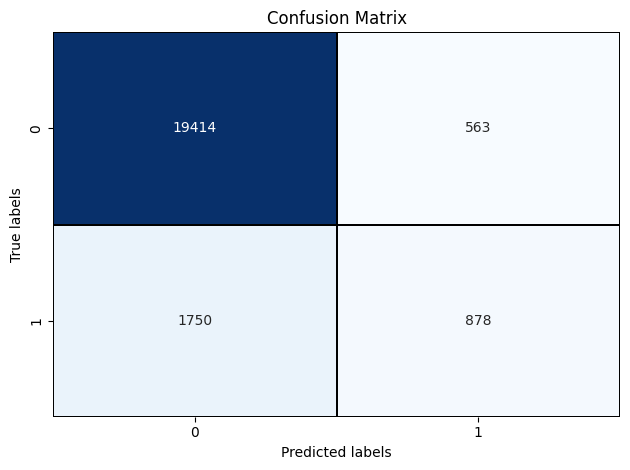

In [218]:
dt_opti_full_df_confusion_mat = confusion_matrix(full_df_target_test_5050, dt_opti.predict(full_df_features_test_5050))
sns.heatmap(dt_opti_full_df_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [349]:
dt_opti_full_df_classification_report = classification_report(full_df_target_test_5050, dt_opti.predict(full_df_features_test_5050), digits=4)
print(dt_opti_full_df_classification_report)

              precision    recall  f1-score   support

           0     0.9020    0.9689    0.9343     19945
           1     0.4755    0.2112    0.2925      2661

    accuracy                         0.8797     22606
   macro avg     0.6887    0.5901    0.6134     22606
weighted avg     0.8518    0.8797    0.8587     22606



### 2) 80/20 split strategy on full dataset

In [206]:
depths = np.arange(1, 11)

dt_full_df_training_accuracies = []
dt_full_df_testing_accuracies = []

for depth in depths:
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=0.05)
    dt_fit = dt.fit(full_df_features_train_8020, full_df_target_train_8020)
    dt_full_df_training_accuracy = dt_fit.score(full_df_features_train_8020, full_df_target_train_8020)
    dt_full_df_testing_accuracy = dt_fit.score(full_df_features_test_8020, full_df_target_test_8020)
    dt_full_df_training_accuracies.append(dt_full_df_training_accuracy)
    dt_full_df_testing_accuracies.append(dt_full_df_testing_accuracy)
    print(f" Depth:{depth}, decision tree training accuracy: {round(dt_full_df_training_accuracy, 4)}, decision tree testing accuracy: {round(dt_full_df_testing_accuracy, 4)}")

 Depth:1, decision tree training accuracy: 0.8831, decision tree testing accuracy: 0.8828
 Depth:2, decision tree training accuracy: 0.8896, decision tree testing accuracy: 0.8881
 Depth:3, decision tree training accuracy: 0.8981, decision tree testing accuracy: 0.8946
 Depth:4, decision tree training accuracy: 0.8981, decision tree testing accuracy: 0.8946
 Depth:5, decision tree training accuracy: 0.8981, decision tree testing accuracy: 0.8946
 Depth:6, decision tree training accuracy: 0.8982, decision tree testing accuracy: 0.8942
 Depth:7, decision tree training accuracy: 0.8982, decision tree testing accuracy: 0.8942
 Depth:8, decision tree training accuracy: 0.8982, decision tree testing accuracy: 0.8942
 Depth:9, decision tree training accuracy: 0.8982, decision tree testing accuracy: 0.8942
 Depth:10, decision tree training accuracy: 0.8982, decision tree testing accuracy: 0.8942


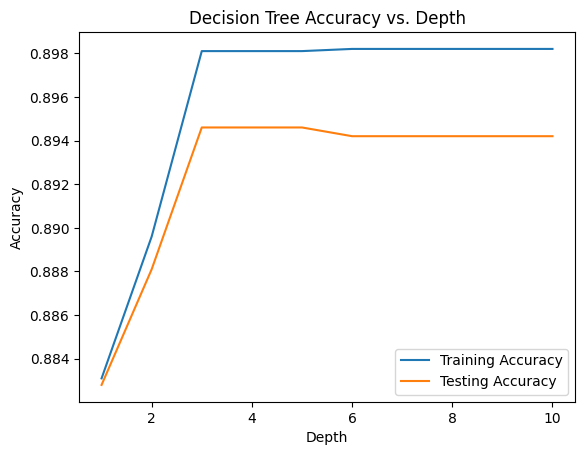

In [207]:
plt.plot(depths, dt_full_df_training_accuracies, label='Training Accuracy')
plt.plot(depths, dt_full_df_testing_accuracies, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.show()

In [74]:
dt_opti = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=0.05)
dt_fit = dt_opti.fit(full_df_features_train_8020, full_df_target_train_8020)
dt_training_accuracy = dt_opti.score(full_df_features_train_8020, full_df_target_train_8020)
dt_testing_accuracy = dt_opti.score(full_df_features_test_8020, full_df_target_test_8020)
dt_precision_test = precision_score(full_df_target_test_8020, dt_opti.predict(full_df_features_test_8020))
dt_recall_test = recall_score(full_df_target_test_8020, dt_opti.predict(full_df_features_test_8020))
print(f"optimal decision tree training accuracy: {round(dt_training_accuracy, 4)}")
print(f"optimal decision tree testing accuracy: {round(dt_testing_accuracy, 4)}")
print(f"optimal decision tree testing precision: {round(dt_precision_test, 4)}")
print(f"optimal decision tree testing recall: {round(dt_recall_test, 4)}")

optimal decision tree training accuracy: 0.8981
optimal decision tree testing accuracy: 0.8946
optimal decision tree testing precision: 0.5835
optimal decision tree testing recall: 0.3528


In [75]:
for feature_imp, variable in zip(dt_opti_fit.feature_importances_,top_10_feature_names):
    print(f"{variable}:{round(feature_imp*100,1)}%")

duration_zscore:69.8%
poutcome_is_success:30.2%
poutcome_is_unknown:0.0%
contact_is_unknown:0.0%
housing:0.0%
pdays_zscore:0.0%
previous_zscore:0.0%
job_is_retired:0.0%
job_is_student:0.0%
campaign_zscore:0.0%


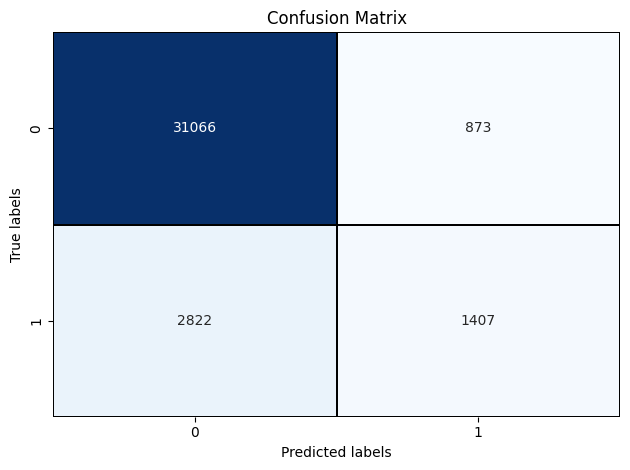

In [220]:
dt_opti_full_df_confusion_mat = confusion_matrix(full_df_target_test_8020, dt_opti.predict(full_df_features_test_8020))
sns.heatmap(dt_opti_full_df_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [221]:
dt_opti_full_df_classification_report = classification_report(full_df_target_test_8020, dt_opti.predict(full_df_features_test_8020))
print(dt_opti_full_df_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     31939
           1       0.62      0.33      0.43      4229

    accuracy                           0.90     36168
   macro avg       0.77      0.65      0.69     36168
weighted avg       0.88      0.90      0.88     36168



### 3) 50/50 split strategy on filtered dataset

In [224]:
depths = np.arange(1, 11)

dt_filtered_df_training_accuracies = []
dt_filtered_df_testing_accuracies = []

for depth in depths:
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=0.05)
    dt_fit = dt.fit(filtered_df_features_train_5050, filtered_df_target_train_5050)
    dt_filtered_df_training_accuracy = dt_fit.score(filtered_df_features_train_5050, filtered_df_target_train_5050)
    dt_filtered_df_testing_accuracy = dt_fit.score(filtered_df_features_test_5050, filtered_df_target_test_5050)
    dt_filtered_df_training_accuracies.append(dt_filtered_df_training_accuracy)
    dt_filtered_df_testing_accuracies.append(dt_filtered_df_testing_accuracy)
    print(f" Depth:{depth}, decision tree training accuracy: {round(dt_filtered_df_training_accuracy, 4)}, decision tree testing accuracy: {round(dt_filtered_df_testing_accuracy, 4)}")

 Depth:1, decision tree training accuracy: 0.8988, decision tree testing accuracy: 0.8995
 Depth:2, decision tree training accuracy: 0.9049, decision tree testing accuracy: 0.9032
 Depth:3, decision tree training accuracy: 0.908, decision tree testing accuracy: 0.9042
 Depth:4, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:5, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:6, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:7, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:8, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:9, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065
 Depth:10, decision tree training accuracy: 0.9102, decision tree testing accuracy: 0.9065


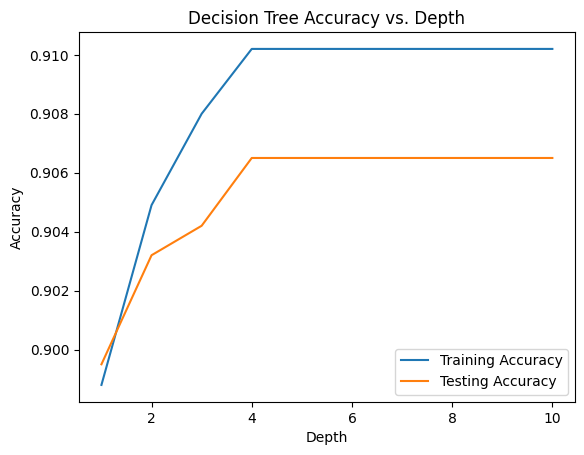

In [225]:
plt.plot(depths, dt_filtered_df_training_accuracies, label='Training Accuracy')
plt.plot(depths, dt_filtered_df_testing_accuracies, label='Testing Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs. Depth')
plt.legend()
plt.show()

In [78]:
dt_opti = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_split=0.05)
dt_fit = dt_opti.fit(filtered_df_features_train_5050, filtered_df_target_train_5050)
dt_training_accuracy = dt_opti.score(filtered_df_features_train_5050, filtered_df_target_train_5050)
dt_testing_accuracy = dt_opti.score(filtered_df_features_test_5050, filtered_df_target_test_5050)
dt_precision_test = precision_score(filtered_df_target_test_5050, dt_opti.predict(filtered_df_features_test_5050))
dt_recall_test = recall_score(filtered_df_target_test_5050, dt_opti.predict(filtered_df_features_test_5050))
print(f"optimal decision tree training accuracy: {round(dt_training_accuracy, 4)}")
print(f"optimal decision tree testing accuracy: {round(dt_testing_accuracy, 4)}")
print(f"optimal decision tree testing precision: {round(dt_precision_test, 4)}")
print(f"optimal decision tree testing recall: {round(dt_recall_test, 4)}")

optimal decision tree training accuracy: 0.9102
optimal decision tree testing accuracy: 0.9065
optimal decision tree testing precision: 0.5841
optimal decision tree testing recall: 0.2406


In [79]:
for feature_imp, variable in zip(dt_opti_fit.feature_importances_,top_10_feature_names):
    print(f"{variable}:{round(feature_imp*100,1)}%")

duration_zscore:69.8%
poutcome_is_success:30.2%
poutcome_is_unknown:0.0%
contact_is_unknown:0.0%
housing:0.0%
pdays_zscore:0.0%
previous_zscore:0.0%
job_is_retired:0.0%
job_is_student:0.0%
campaign_zscore:0.0%


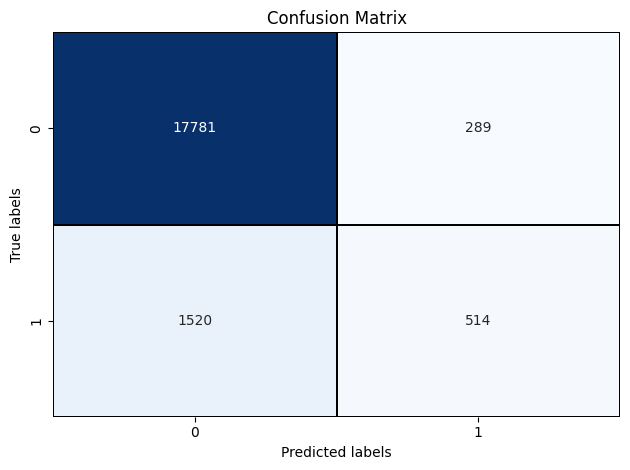

In [228]:
dt_confusion_mat = confusion_matrix(filtered_df_target_test_5050, dt_opti.predict(filtered_df_features_test_5050))
sns.heatmap(dt_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [229]:
dt_opti_filtered_df_classification_report = classification_report(filtered_df_target_test_5050, dt_opti.predict(filtered_df_features_test_5050))
print(dt_opti_filtered_df_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     18070
           1       0.64      0.25      0.36      2034

    accuracy                           0.91     20104
   macro avg       0.78      0.62      0.66     20104
weighted avg       0.89      0.91      0.89     20104



## b) Support Vector Machine

### 1) 50/50 split strategy on full dataset

Hyperparameters tuning

In [22]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01]
}
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(full_df_features_train_5050, full_df_target_train_5050)
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9015262110152621


Support vector classifier with tuned hyperparameters

In [350]:
svc = svm.SVC(C=10, kernel='rbf', gamma=0.1, probability=True) #support vector classifier
svc_fit = svc.fit(full_df_features_train_5050, full_df_target_train_5050)

In [352]:
svm_training_accuracy = svc.score(full_df_features_train_5050, full_df_target_train_5050)
svm_testing_accuracy = svc.score(full_df_features_test_5050, full_df_target_test_5050)
svm_precision = precision_score(full_df_target_test_5050, svc.predict(full_df_features_test_5050))
svm_recall = recall_score(full_df_target_test_5050, svc.predict(full_df_features_test_5050))
print(f"svm training accuracy: {round(svm_training_accuracy, 4)}")
print(f"svm testing accuracy: {round(svm_testing_accuracy, 4)}")
print(f"svm testing precision: {round(svm_precision, 4)}")
print(f"svm testing recall: {round(svm_recall, 4)}")

svm training accuracy: 0.91
svm testing accuracy: 0.9056
svm testing precision: 0.7094
svm testing recall: 0.3348


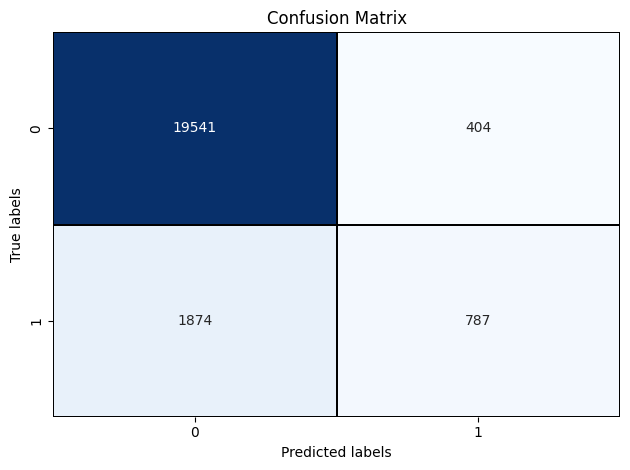

In [29]:
svm_confusion_mat = confusion_matrix(full_df_target_test_5050, svc.predict(full_df_features_test_5050))
sns.heatmap(svm_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [351]:
svm_classification_report = classification_report(full_df_target_test_5050, svc.predict(full_df_features_test_5050), digits=4)
print(svm_classification_report)

              precision    recall  f1-score   support

           0     0.9171    0.9817    0.9483     19945
           1     0.7094    0.3348    0.4549      2661

    accuracy                         0.9056     22606
   macro avg     0.8132    0.6583    0.7016     22606
weighted avg     0.8926    0.9056    0.8902     22606



### 2) 80/20 split strategy on full dataset

In [31]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01]
}
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(full_df_features_train_8020, full_df_target_train_8020)
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.9007686982539134


In [32]:
svc = svm.SVC(C=1, kernel='rbf', gamma=1, probability=True) 
svc_fit = svc.fit(full_df_features_train_8020, full_df_target_train_8020)

In [37]:
svm_training_accuracy = svc.score(full_df_features_train_8020, full_df_target_train_8020)
svm_testing_accuracy = svc.score(full_df_features_test_8020, full_df_target_test_8020)
svm_precision = precision_score(full_df_target_test_8020, svc.predict(full_df_features_test_8020))
svm_recall = recall_score(full_df_target_test_8020, svc.predict(full_df_features_test_8020))
print(f"svm training accuracy: {round(svm_training_accuracy, 4)}")
print(f"svm testing accuracy: {round(svm_testing_accuracy, 4)}")
print(f"svm testing precision: {round(svm_precision, 4)}")
print(f"svm testing recall: {round(svm_recall, 4)}")

svm training accuracy: 0.9105
svm testing accuracy: 0.8998
svm testing precision: 0.6469
svm testing recall: 0.3198


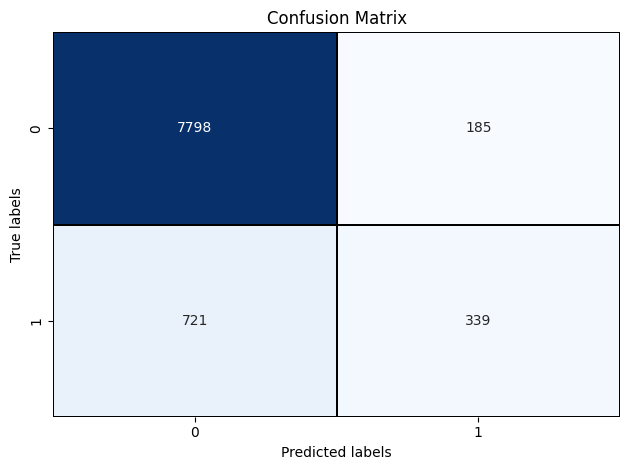

In [38]:
svm_confusion_mat = confusion_matrix(full_df_target_test_8020, svc.predict(full_df_features_test_8020))
sns.heatmap(svm_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [39]:
svm_classification_report = classification_report(full_df_target_test_8020, svc.predict(full_df_features_test_8020))
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7983
           1       0.65      0.32      0.43      1060

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



### 3) 50/50 split strategy on filtered dataset

In [40]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01]
}
model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(filtered_df_features_train_5050, filtered_df_target_train_5050)
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.9117091117404769


In [41]:
svc = svm.SVC(C=10, kernel='rbf', gamma=0.1, probability=True) 
svc_fit = svc.fit(filtered_df_features_train_5050, filtered_df_target_train_5050)

In [42]:
svm_training_accuracy = svc.score(filtered_df_features_train_5050, filtered_df_target_train_5050)
svm_testing_accuracy = svc.score(filtered_df_features_test_5050, filtered_df_target_test_5050)
svm_precision = precision_score(filtered_df_target_test_5050, svc.predict(filtered_df_features_test_5050))
svm_recall = recall_score(filtered_df_target_test_5050, svc.predict(filtered_df_features_test_5050))
print(f"svm training accuracy: {round(svm_training_accuracy, 4)}")
print(f"svm testing accuracy: {round(svm_testing_accuracy, 4)}")
print(f"svm testing precision: {round(svm_precision, 4)}")
print(f"svm testing recall: {round(svm_recall, 4)}")

svm training accuracy: 0.9136
svm testing accuracy: 0.9095
svm testing precision: 0.6398
svm testing recall: 0.2277


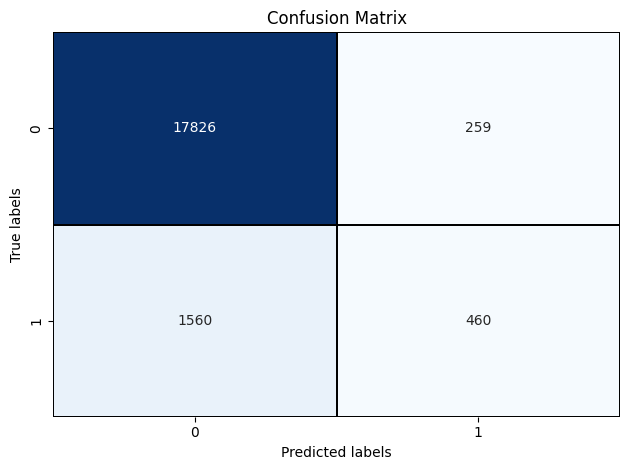

In [43]:
svm_confusion_mat = confusion_matrix(filtered_df_target_test_5050, svc.predict(filtered_df_features_test_5050))
sns.heatmap(svm_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [44]:
svm_classification_report = classification_report(filtered_df_target_test_5050, svc.predict(filtered_df_features_test_5050))
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     18085
           1       0.64      0.23      0.34      2020

    accuracy                           0.91     20105
   macro avg       0.78      0.61      0.64     20105
weighted avg       0.89      0.91      0.89     20105



## c) Neural network models

### 1) 50/50 split strategy on full dataset

In [353]:
hidden_layer_sizes = [(3,), (3, 2), (5,), (10,), (5, 2), (10, 5)]

for layer_sizes in hidden_layer_sizes:
    mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=layer_sizes, random_state=1, max_iter=3000)
    mlpc.fit(full_df_features_train_5050, full_df_target_train_5050)
    
    mlpc_training_accuracy = mlpc.score(full_df_features_train_5050, full_df_target_train_5050)
    mlpc_testing_accuracy = mlpc.score(full_df_features_test_5050, full_df_target_test_5050)

    print(f"Hidden Layer Sizes: {layer_sizes}")
    print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
    print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")

Hidden Layer Sizes: (3,)
mlpc training accuracy: 0.9048
mlpc testing accuracy: 0.9032
Hidden Layer Sizes: (3, 2)
mlpc training accuracy: 0.9067
mlpc testing accuracy: 0.9056
Hidden Layer Sizes: (5,)
mlpc training accuracy: 0.9089
mlpc testing accuracy: 0.9062
Hidden Layer Sizes: (10,)
mlpc training accuracy: 0.9104
mlpc testing accuracy: 0.907
Hidden Layer Sizes: (5, 2)
mlpc training accuracy: 0.9079
mlpc testing accuracy: 0.9055
Hidden Layer Sizes: (10, 5)
mlpc training accuracy: 0.911
mlpc testing accuracy: 0.9064


In [119]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,), random_state=1, max_iter=1000)
mlpc.fit(full_df_features_train_5050, full_df_target_train_5050)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(10,), max_iter=1000,
              random_state=1, solver='lbfgs')

In [120]:
mlpc_training_accuracy = mlpc.score(full_df_features_train_5050, full_df_target_train_5050)
mlpc_testing_accuracy = mlpc.score(full_df_features_test_5050, full_df_target_test_5050)
mlpc_precision = precision_score(full_df_target_test_5050, mlpc.predict(full_df_features_test_5050))
mlpc_recall = recall_score(full_df_target_test_5050, mlpc.predict(full_df_features_test_5050))
print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")
print(f"mlpc testing precision: {round(mlpc_precision, 4)}")
print(f"mlpc testing recall: {round(mlpc_recall, 4)}")

mlpc training accuracy: 0.9091
mlpc testing accuracy: 0.908
mlpc testing precision: 0.6572
mlpc testing recall: 0.4461


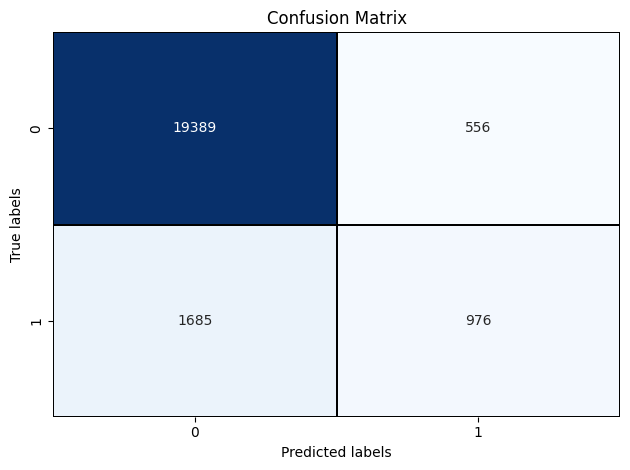

In [54]:
mlpc_confusion_mat = confusion_matrix(full_df_target_test_5050, mlpc.predict(full_df_features_test_5050))
sns.heatmap(mlpc_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [121]:
mlpc_classification_report = classification_report(full_df_target_test_5050, mlpc.predict(full_df_features_test_5050), digits=4)
print(mlpc_classification_report)

              precision    recall  f1-score   support

           0     0.9297    0.9692    0.9490     19962
           1     0.6572    0.4461    0.5314      2643

    accuracy                         0.9080     22605
   macro avg     0.7934    0.7076    0.7402     22605
weighted avg     0.8978    0.9080    0.9002     22605



### 2) 80/20 split strategy on full dataset

In [83]:
hidden_layer_sizes = [(5,), (10,), (5, 2), (10, 5)]

for layer_sizes in hidden_layer_sizes:
    mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=layer_sizes, random_state=1, max_iter=3000)
    mlpc.fit(full_df_features_train_8020, full_df_target_train_8020)
    
    mlpc_training_accuracy = mlpc.score(full_df_features_train_8020, full_df_target_train_8020)
    mlpc_testing_accuracy = mlpc.score(full_df_features_test_8020, full_df_target_test_8020)

    print(f"Hidden Layer Sizes: {layer_sizes}")
    print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
    print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")

Hidden Layer Sizes: (5,)
mlpc training accuracy: 0.9024
mlpc testing accuracy: 0.8976
Hidden Layer Sizes: (10,)
mlpc training accuracy: 0.9027
mlpc testing accuracy: 0.8994
Hidden Layer Sizes: (5, 2)
mlpc training accuracy: 0.902
mlpc testing accuracy: 0.8979
Hidden Layer Sizes: (10, 5)
mlpc training accuracy: 0.9046
mlpc testing accuracy: 0.8998


In [51]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
mlpc.fit(full_df_features_train_8020, full_df_target_train_8020)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

In [56]:
mlpc_training_accuracy = mlpc.score(full_df_features_train_8020, full_df_target_train_8020)
mlpc_testing_accuracy = mlpc.score(full_df_features_test_8020, full_df_target_test_8020)
mlpc_precision = precision_score(full_df_target_test_8020, mlpc.predict(full_df_features_test_8020))
mlpc_recall = recall_score(full_df_target_test_8020, mlpc.predict(full_df_features_test_8020))
print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")
print(f"mlpc testing precision: {round(mlpc_precision, 4)}")
print(f"mlpc testing recall: {round(mlpc_recall, 4)}")

mlpc training accuracy: 0.9021
mlpc testing accuracy: 0.9015
mlpc testing precision: 0.6365
mlpc testing recall: 0.3717


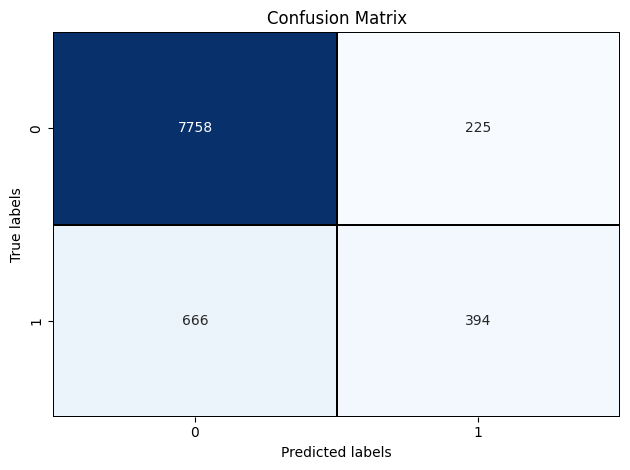

In [57]:
mlpc_confusion_mat = confusion_matrix(full_df_target_test_8020, mlpc.predict(full_df_features_test_8020))
sns.heatmap(mlpc_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [58]:
mlpc_classification_report = classification_report(full_df_target_test_8020, mlpc.predict(full_df_features_test_8020))
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     18085
           1       0.64      0.23      0.34      2020

    accuracy                           0.91     20105
   macro avg       0.78      0.61      0.64     20105
weighted avg       0.89      0.91      0.89     20105



### 3) 50/50 split strategy on filtered dataset

In [62]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
mlpc.fit(filtered_df_features_train_5050, filtered_df_target_train_5050)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

Precision score is being set to 0.0 because there are no predicted samples for one or more classes

In [65]:
mlpc_training_accuracy = mlpc.score(filtered_df_features_train_5050, filtered_df_target_train_5050)
mlpc_testing_accuracy = mlpc.score(filtered_df_features_test_5050, filtered_df_target_test_5050)
mlpc_precision = precision_score(filtered_df_target_test_5050, mlpc.predict(filtered_df_features_test_5050), zero_division=0)
mlpc_recall = recall_score(filtered_df_target_test_5050, mlpc.predict(filtered_df_features_test_5050), zero_division=0)
print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")
print(f"mlpc testing precision: {round(mlpc_precision, 4)}")
print(f"mlpc testing recall: {round(mlpc_recall, 4)}")

mlpc training accuracy: 0.8988
mlpc testing accuracy: 0.8995
mlpc testing precision: 0.0
mlpc testing recall: 0.0


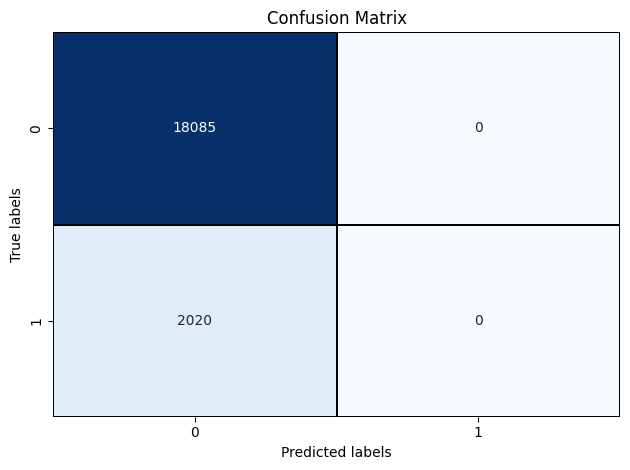

In [61]:
mlpc_confusion_mat = confusion_matrix(filtered_df_target_test_5050, mlpc.predict(filtered_df_features_test_5050))
sns.heatmap(mlpc_confusion_mat, annot=True, cmap="Blues", fmt="d", linewidths=0.01, linecolor='black', cbar=False)

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [69]:
mlpc_classification_report = classification_report(filtered_df_target_test_5050, mlpc.predict(filtered_df_features_test_5050), zero_division=0)
print(svm_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     18085
           1       0.64      0.23      0.34      2020

    accuracy                           0.91     20105
   macro avg       0.78      0.61      0.64     20105
weighted avg       0.89      0.91      0.89     20105



## 4.2. ML models with fairness constraint

Average total variation

In [37]:
contingency_table = pd.crosstab(df_concat['subscription'], df_concat['gender'])
contingency_table

gender,0,1
subscription,,
0,18071,21851
1,3923,1366


In [38]:
female_df = df_concat[df_concat['gender'] == 1]
male_df = df_concat[df_concat['gender'] == 0]

# Calculate the means of the subscription column
female_expected_output = female_df['subscription'].mean()
male_expected_output = male_df['subscription'].mean()

# Print the results
print(f"E(Y|Z=1): {female_expected_output}")
print(f"E(Y|Z=0): {male_expected_output}")

E(Y|Z=1): 0.05883619761381746
E(Y|Z=0): 0.17836682731654088


In [39]:
mean_subscription_given_gender = df_concat.groupby('gender')['subscription'].mean()
mean_subscription_given_gender

gender
0    0.178367
1    0.058836
Name: subscription, dtype: float64

## 1st strategy - excluding sensitive variables of the feature matrix

Remove sensitive variable

In [40]:
fair_df_target = full_df_target.copy()
fair_df_target 

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: subscription, Length: 45211, dtype: int64

In [41]:
full_df_features = df_concat.loc[:, top_10_feature_names]
fair_df_features = full_df_features.drop("gender", axis=1)
fair_df_features

,duration_zscore,poutcome_is_success,poutcome_is_unknown,contact_is_unknown,housing,pdays_zscore,previous_zscore,job_is_retired,job_is_student
0,0.011016,0,1,1,1,-0.411453,-0.251940,0,0
1,-0.416127,0,1,1,1,-0.411453,-0.251940,0,0
2,-0.707361,0,1,1,1,-0.411453,-0.251940,0,0
3,-0.645231,0,1,1,1,-0.411453,-0.251940,0,0
4,-0.233620,0,1,1,0,-0.411453,-0.251940,0,0
...,...,...,...,...,...,...,...,...,...
45206,2.791329,0,1,0,0,-0.411453,-0.251940,0,0
45207,0.768224,0,1,0,0,-0.411453,-0.251940,1,0
45208,3.373797,1,0,0,0,1.436189,1.050473,1,0
45209,0.970146,0,1,0,0,-0.411453,-0.251940,0,0


In [42]:
# Splitting into training and testing sets
fair_df_features_train_5050, fair_df_features_test_5050, fair_df_target_train_5050, fair_df_target_test_5050 = train_test_split(fair_df_features, fair_df_target, test_size=0.5, random_state=42)

Decision tree

In [43]:
depths = np.arange(1, 11)

dt_fair_df_training_accuracies = []
dt_fair_df_testing_accuracies = []

for depth in depths:
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_split=0.05)
    dt_fit = dt.fit(fair_df_features_train_5050, fair_df_target_train_5050)
    dt_fair_df_training_accuracy = dt_fit.score(fair_df_features_train_5050, fair_df_target_train_5050) 
    dt_fair_df_testing_accuracy = dt_fit.score(fair_df_features_test_5050, fair_df_target_test_5050)
    dt_fair_df_training_accuracies.append(dt_fair_df_training_accuracy)
    dt_fair_df_testing_accuracies.append(dt_fair_df_testing_accuracy)
    print(f" Depth:{depth}, decision tree training accuracy: {round(dt_fair_df_training_accuracy, 4)}, decision tree testing accuracy: {round(dt_fair_df_testing_accuracy, 4)}")

 Depth:1, decision tree training accuracy: 0.8837, decision tree testing accuracy: 0.8823
 Depth:2, decision tree training accuracy: 0.8912, decision tree testing accuracy: 0.8901
 Depth:3, decision tree training accuracy: 0.8977, decision tree testing accuracy: 0.8971
 Depth:4, decision tree training accuracy: 0.8977, decision tree testing accuracy: 0.8971
 Depth:5, decision tree training accuracy: 0.8977, decision tree testing accuracy: 0.8971
 Depth:6, decision tree training accuracy: 0.8978, decision tree testing accuracy: 0.8972
 Depth:7, decision tree training accuracy: 0.8978, decision tree testing accuracy: 0.8972
 Depth:8, decision tree training accuracy: 0.8978, decision tree testing accuracy: 0.8971
 Depth:9, decision tree training accuracy: 0.8978, decision tree testing accuracy: 0.8971
 Depth:10, decision tree training accuracy: 0.8978, decision tree testing accuracy: 0.8971


In [361]:
dt_opti = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=0.05)
dt_opti_fit = dt_opti.fit(fair_df_features_train_5050, fair_df_target_train_5050)
dt_training_accuracy = dt_opti.score(fair_df_features_train_5050, fair_df_target_train_5050)
dt_testing_accuracy = dt_opti.score(fair_df_features_test_5050, fair_df_target_test_5050)
dt_precision_test = precision_score(fair_df_target_test_5050, dt_opti.predict(fair_df_features_test_5050))
dt_recall_test = recall_score(fair_df_target_test_5050, dt_opti.predict(fair_df_features_test_5050))
print(f"optimal decision tree training accuracy: {round(dt_training_accuracy, 4)}")
print(f"optimal decision tree testing accuracy: {round(dt_testing_accuracy, 4)}")
print(f"optimal decision tree testing precision: {round(dt_precision_test, 4)}")
print(f"optimal decision tree testing recall: {round(dt_recall_test, 4)}")

optimal decision tree training accuracy: 0.8977
optimal decision tree testing accuracy: 0.8971
optimal decision tree testing precision: 0.6167
optimal decision tree testing recall: 0.3326


In [362]:
dt_opti_fair_df_classification_report = classification_report(fair_df_target_test_5050, dt_opti.predict(fair_df_features_test_5050), digits=4)
print(dt_opti_fair_df_classification_report)

              precision    recall  f1-score   support

           0     0.9161    0.9724    0.9434     19945
           1     0.6167    0.3326    0.4321      2661

    accuracy                         0.8971     22606
   macro avg     0.7664    0.6525    0.6878     22606
weighted avg     0.8809    0.8971    0.8832     22606



SVM 

In [363]:
svc = svm.SVC(C=10, kernel='rbf', gamma=0.1, probability=True) #support vector classifier
svc_fit = svc.fit(fair_df_features_train_5050, fair_df_target_train_5050)

In [364]:
svm_training_accuracy = svc.score(fair_df_features_train_5050, fair_df_target_train_5050)
svm_testing_accuracy = svc.score(fair_df_features_test_5050, fair_df_target_test_5050)
svm_precision = precision_score(fair_df_target_test_5050, svc.predict(fair_df_features_test_5050))
svm_recall = recall_score(fair_df_target_test_5050, svc.predict(fair_df_features_test_5050))
print(f"svm training accuracy: {round(svm_training_accuracy, 4)}")
print(f"svm testing accuracy: {round(svm_testing_accuracy, 4)}")
print(f"svm testing precision: {round(svm_precision, 4)}")
print(f"svm testing recall: {round(svm_recall, 4)}")

svm training accuracy: 0.9052
svm testing accuracy: 0.8995
svm testing precision: 0.6653
svm testing recall: 0.295


In [365]:
svm_classification_report = classification_report(fair_df_target_test_5050, svc.predict(fair_df_features_test_5050), digits=4)
print(svm_classification_report)

              precision    recall  f1-score   support

           0     0.9124    0.9802    0.9451     19945
           1     0.6653    0.2950    0.4087      2661

    accuracy                         0.8995     22606
   macro avg     0.7888    0.6376    0.6769     22606
weighted avg     0.8833    0.8995    0.8820     22606



NN

In [366]:
hidden_layer_sizes = [(3,), (3, 2), (5,), (10,), (5, 2), (10, 5)]

for layer_sizes in hidden_layer_sizes:
    mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=layer_sizes, random_state=1, max_iter=3000)
    mlpc.fit(fair_df_features_train_5050, fair_df_target_train_5050)
    
    mlpc_training_accuracy = mlpc.score(fair_df_features_train_5050, fair_df_target_train_5050)
    mlpc_testing_accuracy = mlpc.score(fair_df_features_test_5050, fair_df_target_test_5050)

    print(f"Hidden Layer Sizes: {layer_sizes}")
    print(f"mlpc training accuracy: {round(mlpc_training_accuracy, 4)}")
    print(f"mlpc testing accuracy: {round(mlpc_testing_accuracy, 4)}")

Hidden Layer Sizes: (3,)
mlpc training accuracy: 0.9003
mlpc testing accuracy: 0.8989
Hidden Layer Sizes: (3, 2)
mlpc training accuracy: 0.9041
mlpc testing accuracy: 0.901
Hidden Layer Sizes: (5,)
mlpc training accuracy: 0.9042
mlpc testing accuracy: 0.901
Hidden Layer Sizes: (10,)
mlpc training accuracy: 0.9036
mlpc testing accuracy: 0.8998
Hidden Layer Sizes: (5, 2)
mlpc training accuracy: 0.9041
mlpc testing accuracy: 0.9007
Hidden Layer Sizes: (10, 5)
mlpc training accuracy: 0.9068
mlpc testing accuracy: 0.8996


In [367]:
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1, max_iter=1000)
mlpc.fit(fair_df_features_train_5050, fair_df_target_train_5050)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

In [368]:
mlpc_classification_report = classification_report(fair_df_target_test_5050, mlpc.predict(fair_df_features_test_5050), digits=4)
print(mlpc_classification_report)

              precision    recall  f1-score   support

           0     0.9220    0.9698    0.9453     19945
           1     0.6300    0.3852    0.4781      2661

    accuracy                         0.9010     22606
   macro avg     0.7760    0.6775    0.7117     22606
weighted avg     0.8876    0.9010    0.8903     22606



## 2nd strategy - preprocessing techniques

fix odd dataset issue

In [ ]:
df_concat.drop(df_concat.tail(1).index, inplace=True)

In [83]:
full_df_target = df_concat['subscription']
full_df_features = df_concat.loc[:, top_10_feature_names]
full_df_features_train_5050, full_df_features_test_5050, full_df_target_train_5050, full_df_target_test_5050 = train_test_split(full_df_features, full_df_target, test_size=0.5, random_state=42)

In [103]:
# Convert the sensitive features to an array
sensitive_features = df_concat['gender'].values
sensitive_features.shape

(45210,)

### Fair Decision tree model

In [114]:
# Convert the sensitive features to an array
sensitive_features = full_df_features_train_5050['gender'].values

# Create an DT classifier model
classifier = tree.DecisionTreeClassifier()

# Define the fairness constraint
constraint = DemographicParity()

# Define the Fairlearn reduction algorithm
fair_dt = ExponentiatedGradient(classifier, constraint)

# Fit the reduction fair_dt to the training data
fair_dt.fit(full_df_features_train_5050, full_df_target_train_5050, sensitive_features=sensitive_features)

# Make predictions on the test set
fair_dt_predictions = fair_dt.predict(full_df_features_test_5050)

# Calculate the equalized odds difference
eod = equalized_odds_difference(full_df_target_test_5050, fair_dt_predictions, sensitive_features=sensitive_features)
print("Equalized Odds Difference:", eod)

Equalized Odds Difference: 0.04991922825750722


In [115]:
fair_dt_classification_report = classification_report(full_df_target_test_5050, fair_dt_predictions, digits=4)
print(fair_dt_classification_report)

              precision    recall  f1-score   support

           0     0.9225    0.9195    0.9210     19962
           1     0.4064    0.4162    0.4112      2643

    accuracy                         0.8607     22605
   macro avg     0.6644    0.6678    0.6661     22605
weighted avg     0.8621    0.8607    0.8614     22605



### Fair SVM model

In [104]:
# Convert the sensitive features to an array
sensitive_features = full_df_features_train_5050['gender'].values

# Create an SVM classifier model
classifier = SVC()

# Define the fairness constraint
constraint = DemographicParity()

# Define the Fairlearn reduction algorithm
fair_svm = ExponentiatedGradient(classifier, constraint)

# Fit the reduction fair_svm to the training data
fair_svm.fit(full_df_features_train_5050, full_df_target_train_5050, sensitive_features=sensitive_features)

# Make predictions on the test set
fair_svm_predictions = fair_svm.predict(full_df_features_test_5050)

# Calculate the equalized odds difference
eod = equalized_odds_difference(full_df_target_test_5050, fair_svm_predictions, sensitive_features=sensitive_features)
print("Equalized Odds Difference:", eod)

Equalized Odds Difference: 0.01242681850990457


In [106]:
fair_svm_classification_report = classification_report(full_df_target_test_5050, fair_svm_predictions, digits=4)
print(fair_svm_classification_report)

              precision    recall  f1-score   support

           0     0.9087    0.9838    0.9448     19962
           1     0.6744    0.2531    0.3681      2643

    accuracy                         0.8984     22605
   macro avg     0.7915    0.6185    0.6564     22605
weighted avg     0.8813    0.8984    0.8773     22605



### Neural Network model

In [123]:
mlpc_predictions = mlpc.predict(full_df_features_test_5050)

In [124]:
initial_eod = equalized_odds_difference(full_df_target_train_5050, mlpc_predictions, sensitive_features=sensitive_features)
initial_eod

0.02410675129129715

In [125]:
min_samples_per_group = 1000
unique_subgroups = np.unique(sensitive_features)

# Define the maximum number of samples per subgroup while satisfying the EOD constraint
max_samples_per_subgroup = int(min_samples_per_group * (1 + initial_eod))

# Create a subsample that satisfies the EOD constraint
subsample_indices = []
for subgroup in unique_subgroups:
    subgroup_indices = np.where(sensitive_features == subgroup)[0]
    subgroup_size = len(subgroup_indices)
    subgroup_samples = min(subgroup_size, max_samples_per_subgroup)
    subsample_indices.extend(np.random.choice(subgroup_indices, size=subgroup_samples, replace=False))

# Create the subsample from the indices
subsample_features = full_df_features_train_5050[subsample_indices]
subsample_target = full_df_target_train_5050[subsample_indices]
subsample_sensitive_features = sensitive_features[subsample_indices]

# Fit the neural network classifier on the subsample
classifier.fit(subsample_features, subsample_target)

# Make predictions on the test set
predictions = classifier.predict(full_df_features_test_5050)

# Calculate the equalized odds difference for the subsample
eod_subsample = equalized_odds_difference(full_df_target_test_5050, predictions, sensitive_features=sensitive_features)
print("Equalized Odds Difference for Subsample:", eod_subsample)


KeyError: "None of [Int64Index([17994, 12171,  5898,  3983,  6184,  3682, 21441,  2789,  8898,\n             4902,\n            ...\n            12116, 21597,  5921, 10708,  1308,  3910, 15275,  5734, 12447,\n              429],\n           dtype='int64', length=2048)] are in the [columns]"